### 0. Загрузка и проверка данных

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('bank-full.csv', sep=';')
columns_to_keep = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 
                   'campaign', 'pdays', 'previous', 'poutcome', 'y']
df = df[columns_to_keep]
print("Пропущенные значения:\n", df.isnull().sum())


Пропущенные значения:
 age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


### 1. Какое самое частое значение (mode) для столбца education?

In [4]:
mode_education = df['education'].mode()[0]
print("Самое частое значение в education:", mode_education)

Самое частое значение в education: secondary


### 2. Корреляционная матрица для числовых признаков

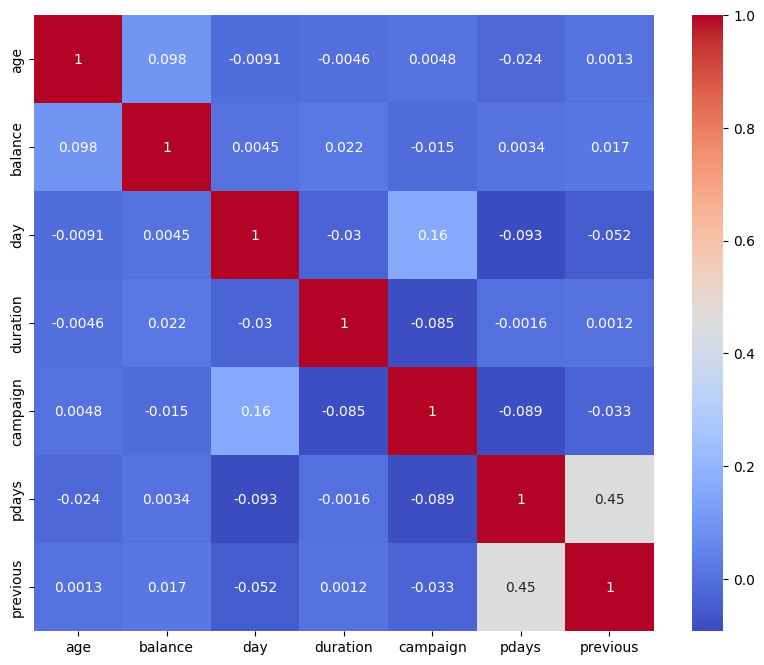

Признаки с наибольшей корреляцией: pdays  previous    0.45482
dtype: float64


In [6]:
numeric_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()
max_corr = correlation_matrix.unstack().sort_values(ascending=False)
max_corr_pairs = max_corr[max_corr < 1].head(1)
print("Признаки с наибольшей корреляцией:", max_corr_pairs)

### 3. Взаимная информация между y и категориальными переменными

#### Кодируем переменную y

In [12]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})


#### Разделение данных на тренировочный/валидационный/тестовый наборы

In [13]:
X = df.drop('y', axis=1)
y = df['y']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#### Рассчитываем взаимную информацию для категориальных переменных

In [17]:
categorical_columns = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']
encoder = OneHotEncoder(sparse_output=False, drop='first')

X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_columns]), 
                               columns=encoder.get_feature_names_out())

X_train_encoded = pd.concat([X_train_encoded, X_train.drop(categorical_columns, axis=1).reset_index(drop=True)], axis=1)

mutual_info = mutual_info_classif(X_train_encoded, y_train, discrete_features=True)
mi_series = pd.Series(mutual_info, index=X_train_encoded.columns).sort_values(ascending=False)

print("Взаимная информация:\n", mi_series)
print("Переменная с наибольшей взаимной информацией:", mi_series.idxmax())

Взаимная информация:
 balance                0.119649
duration               0.102033
pdays                  0.037803
poutcome_success       0.027674
age                    0.014727
contact_unknown        0.014208
previous               0.013353
poutcome_unknown       0.012371
housing_yes            0.009464
day                    0.006802
month_oct              0.006174
month_may              0.005491
month_sep              0.004932
campaign               0.004685
month_mar              0.004480
job_retired            0.002635
job_blue-collar        0.002550
education_tertiary     0.002158
job_student            0.002106
marital_married        0.001987
marital_single         0.001920
month_dec              0.001725
education_secondary    0.000669
month_jul              0.000663
month_feb              0.000544
poutcome_other         0.000457
job_management         0.000454
job_services           0.000408
month_jun              0.000290
job_unemployed         0.000231
contact_telephone 

### 4. Логистическая регрессия

In [18]:
X_val_encoded = pd.concat([pd.DataFrame(encoder.transform(X_val[categorical_columns]), 
                                        columns=encoder.get_feature_names_out()), 
                           X_val.drop(categorical_columns, axis=1).reset_index(drop=True)], axis=1)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train_encoded, y_train)

y_pred_val = model.predict(X_val_encoded)
accuracy = accuracy_score(y_val, y_pred_val)
print("Точность на валидационном наборе:", round(accuracy, 2))

Точность на валидационном наборе: 0.9


### Вопрос 5

In [28]:
def evaluate_without_feature(feature_name, X_train_encoded, y_train, X_val_encoded, y_val):
    X_train_new = X_train_encoded.drop(columns=[feature_name])
    X_val_new = X_val_encoded.drop(columns=[feature_name])
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train_new, y_train)
    y_pred_val = model.predict(X_val_new)
    return accuracy_score(y_val, y_pred_val)

base_accuracy = accuracy_score(y_val, y_pred_val)
features = X_train_encoded.columns
feature_diffs = {}
for feature in features:
    accuracy_without_feature = evaluate_without_feature(feature, X_train_encoded, y_train, X_val_encoded, y_val)
    feature_diffs[feature] = base_accuracy - accuracy_without_feature


least_important_feature = min(feature_diffs, key=feature_diffs.get)
print("Признак с наименьшей разницей в точности:", least_important_feature)


Признак с наименьшей разницей в точности: month_jul


### Вопрос 6

In [29]:
Cs = [0.01, 0.1, 1, 10, 100]
best_accuracy = 0
best_C = None

for C in Cs:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train_encoded, y_train)
    y_pred_val = model.predict(X_val_encoded)
    accuracy = accuracy_score(y_val, y_pred_val)
    print(f"Точность при C={C}: {round(accuracy, 3)}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_C = C

print(f"Лучшее значение C: {best_C} с точностью: {round(best_accuracy, 3)}")

Точность при C=0.01: 0.898
Точность при C=0.1: 0.9
Точность при C=1: 0.9
Точность при C=10: 0.901
Точность при C=100: 0.901
Лучшее значение C: 100 с точностью: 0.901
